Number of images found:  2048
Number of labels found:  2048
Number of unique characters:  10
Characters present:  ['*', '4', '5', 'A', 'B', 'C', 'D', 'E', 'F', 'G']


2024-08-20 16:31:23.738393: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


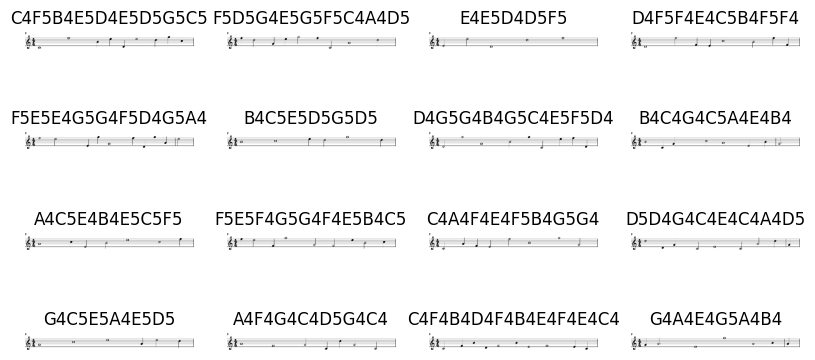

In [1]:
import keras
import tensorflow as tf
import numpy as np

from jiwer import wer

import matplotlib.pyplot as plt

from consonance.models.omr import build_model, ctc_decode, \
    decode_batch_predictions, num_to_char, train_dataset, validation_dataset

In [2]:
model = build_model()
# model.summary()

In [3]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 302ms/step - loss: 958.1016 - val_loss: 537.6564
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 413ms/step - loss: 528.7385 - val_loss: 522.1505
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 49s 420ms/step - loss: 516.8607 - val_loss: 503.7640
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 50s 435ms/step - loss: 501.5580 - val_loss: 443.3416
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 49s 420ms/step - loss: 433.0250 - val_loss: 397.6925
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 49s 425ms/step - loss: 386.2172 - val_loss: 364.3858
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 49s 419ms/step - loss: 375.0347 - val_loss: 367.9050
Epoch 8/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 49s 424ms/step - loss: 366.8641 - val_loss: 394.2380
Epoch 9/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 54s 464ms/step - loss: 363.2370 - val_loss: 352.5297
Epoch 10/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 51s 441ms/step - loss: 355.1191 - val_loss: 349.0677
Epoch 11/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 62s 539ms/step - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


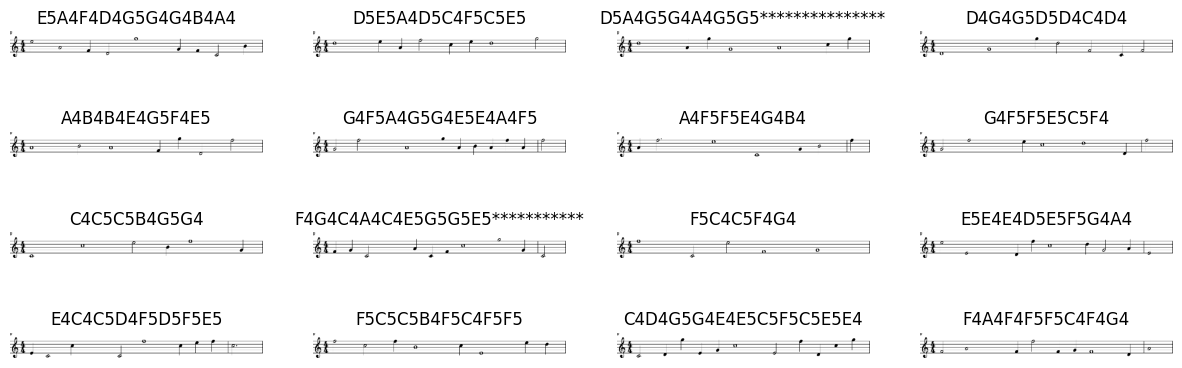

In [6]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)

#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        label = label.strip('*')
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"{pred_texts[i]}".strip("[UNK]")
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [9]:
from jiwer import wer
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch['image'], batch['label']
    batch_predictions = prediction_model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        label = label.strip('[UNK]').strip('*')
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9902
----------------------------------------------------------------------------------------------------
Target    : E5A4F4D4G5G4F4C4B4
Prediction: E5A4F4D4G5G4G4B4A4
----------------------------------------------------------------------------------------------------
Target    : G5G4F5G5D5G4D4C4
Prediction: G5G4F5G5G5G4D4E4
------------------------------------------------------

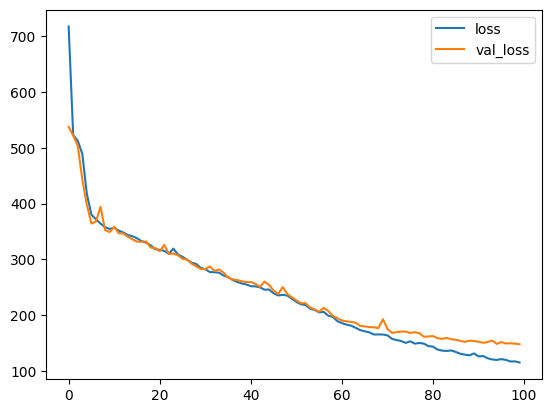

In [12]:
l = history.history
l, vl = l['loss'], l['val_loss']
plt.plot(l, label='loss')
plt.plot(vl, label='val_loss')
plt.legend()